# Digit Recognizer 
A fast.ai implementation for the MNIST Digit Recognizer competition on kaggle. https://www.kaggle.com/c/digit-recognizer 

In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy,error_rate

Below is a custom `ImageItemList` that allows us to load the kaggle datasets. Essentially, the images are stored as a label plus a pixel array wrapped up in a csv file.

In [2]:
class CustomImageItemList(ImageItemList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values, axis=1).values
        return res

## Training
found something somewhere that caused me to set `num_workers` equal to zero. Was getting an error and at the end of the day it seems it was pytorch/windows thing and that was the work around.

In [3]:
# note: there are no labels in a test set, so we set the imgIdx to begin at the 0 col
test = CustomImageItemList.from_csv_custom(path='./data', csv_name='test.csv', imgIdx=0)

In [4]:
#tfms = get_transforms(do_flip=False)
data = (CustomImageItemList.from_csv_custom(path='./data', csv_name='train.csv')
                           .random_split_by_pct(.2)
                           .label_from_df(cols='label')
                           .add_test(test, label=0)
                           #.transform(tfms)
                           .databunch(bs=64, num_workers=0))
                          

In [5]:
learn = create_cnn(data, arch=models.resnet50, metrics=[accuracy,error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


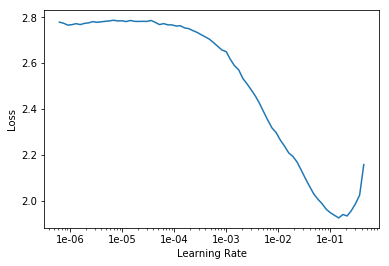

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
lr = 1e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.195766,0.153604,0.954286,0.045714
2,0.110040,0.085524,0.975357,0.024643
3,0.067824,0.051207,0.986786,0.013214
4,0.025439,0.027548,0.991905,0.008095


In [ ]:
learn.save('stage-1')

In [ ]:
# tweak all the layers just to see if we can get a little extra performance
learn.unfreeze()
learn.fit_one_cycle(1)

In [ ]:
learn.validate()

In [ ]:
learn.save('stage-2')

## Interpreting Results

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

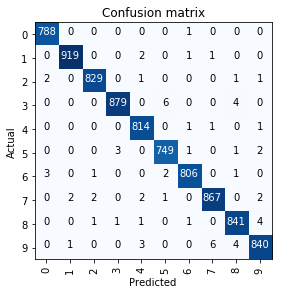

In [9]:
interp.plot_confusion_matrix()

In [10]:
interp.most_confused()

[(3, 5, 6),
 (9, 7, 6),
 (3, 8, 4),
 (8, 9, 4),
 (9, 8, 4),
 (5, 3, 3),
 (6, 0, 3),
 (9, 4, 3),
 (1, 4, 2),
 (2, 0, 2),
 (5, 9, 2),
 (6, 5, 2),
 (7, 1, 2),
 (7, 2, 2),
 (7, 4, 2),
 (7, 9, 2)]

## Generate Competition File

In [11]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [24]:
res_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
res_df.to_csv(f'./data/digit-recognition-submission.csv', index=False)